# Trabajo Semanal 3
### Joaquin Ezequiel Alvarez Olmedo

El trabajo semanal 3 consiste en diseñar un filtro que cumpla con la siguiente plantilla de diseño:

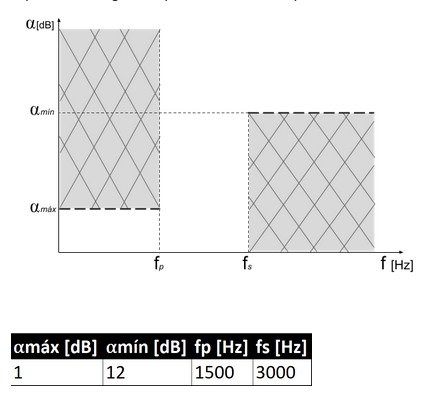

Lo primero que debemos calcular es el orden del filtro y su $ \xi^{2} $:

$ \xi^{2} = 10^{\frac{\alpha max}{10}} - 1 = 10^{\frac{1}{10}} - 1 = 0.259 $

Con este dato estamos seguros que debemos aproximar por Chebyshev ($ \xi^{2} \neq 1 $). 

$ \alpha min = 10\log{(1 + \xi^{2}\cosh^{2}({n\cosh^{-1}{(w_s)}})} = 10\log{(1 + 0.259\cosh^{2}(1.317n))} $ Donde $ w_s = 2 $, normalizada respecto de $ w_p $

$ n = 2.06 $, redondeamos a $ n = 3 $ ya que el filtro de orden 2 no sera capaz de cumplir con la atenuacion pedida en la plantilla.

Con estos datos, armamos $ |T(jw)|^{2} $:

$ |T(jw)|^{2} = \frac{1}{1 + 0.259C_3^{2}(w)} $

Desarrollamos C3:

$ C_n = 2w*C(n-1) - C(n-2) $

$ C_0 = 1 $

$ C_1 = w $

$ C_2 = 2w^{2} - 1 $

$ C_3 = 4w^{3} - 3w $

$ |T(jw)|^{2} = \frac{4}{16w^{6} - 24w^{4} + 9w^{2} + 4} $

Para obtener T(S) resuelve por parte de función. A partir de este punto el álgebra tiende a ponerse tediosa. Para evitar errores algebraicos, simulamos:

#### Chebyshev1_ord_3_rip_1_att_12

<IPython.core.display.Math object>

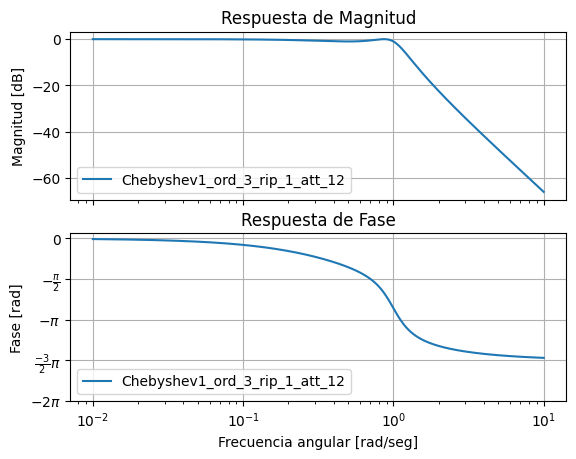

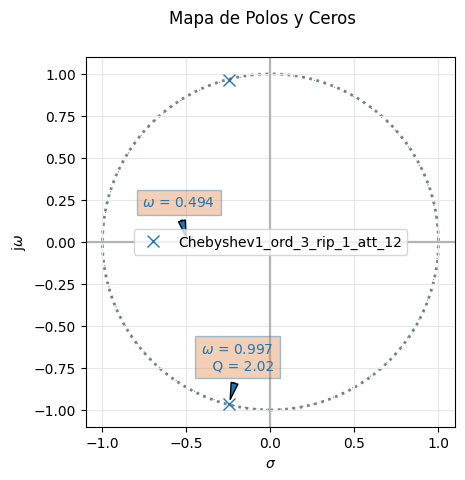

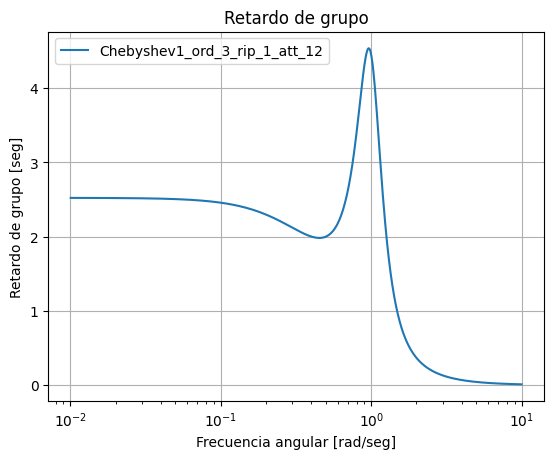

In [1]:
#%% Importamos librerias

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as sig
from pytc2.sistemas_lineales import analyze_sys, pretty_print_bicuad_omegayq, tf2sos_analog, pretty_print_SOS
from pytc2.general import print_subtitle

#%% Funcion que arma las transferencias de filtros de maxima planicidad

def sim_aprox(aproxs, orders2analyze, ripple, attenuation):

    all_sys = []
    filter_names = []

    for (this_aprox, this_order, this_ripple, this_att) in zip(aproxs, orders2analyze, ripple, attenuation):

        if this_aprox == 'Butterworth':

            z,p,k = sig.buttap(this_order)

            eps = np.sqrt( 10**(this_ripple/10) - 1 )
            num, den = sig.zpk2tf(z,p,k)
            num, den = sig.lp2lp(num, den, eps**(-1/this_order))

            z,p,k = sig.tf2zpk(num, den)

        elif this_aprox == 'Chebyshev1':

            z,p,k = sig.cheb1ap(this_order, this_ripple)

        elif this_aprox == 'Chebyshev2':

            z,p,k = sig.cheb2ap(this_order, this_att)

        elif this_aprox == 'Bessel':

            z,p,k = sig.besselap(this_order, norm='delay')

        elif this_aprox == 'Cauer':

            z,p,k = sig.ellipap(this_order, this_ripple, this_att)


        num, den = sig.zpk2tf(z,p,k)

        
        all_sys.append(sig.TransferFunction(num,den))

        this_label = this_aprox + '_ord_' + str(this_order) + '_rip_' + str(this_ripple)+ '_att_' + str(this_att)
        
        print_subtitle(this_label)
        # factorizamos en SOS's
        this_sos = tf2sos_analog(num, den)
        
        pretty_print_SOS(this_sos, mode='omegayq')
        
        filter_names.append(this_label)
        
    # el caracter "_" descarta la salida de la función
    _ = analyze_sys( all_sys, filter_names )

    return( all_sys, filter_names )

#%% En esta seccion elegimos el tipo de filtro que buscamos simular

#aprox_name = 'Butterworth'
aprox_name = 'Chebyshev1'
#aprox_name = 'Chebyshev2'
#aprox_name = 'Bessel'
#aprox_name = 'Cauer'

# parametrizamos el orden para cada aproximación
orders2analyze = [3]

# Mismo requerimiento de ripple y atenuación
aproxs = [aprox_name] * len(orders2analyze)
ripple = [1] * len(orders2analyze) # Alfa maximo en dB
attenuation = [12] * len(orders2analyze) # Alfa minimo en dB

( all_sys, filter_names ) = sim_aprox(aproxs, orders2analyze, ripple, attenuation)


Hagamos zoom en la respuesta de magnitud:

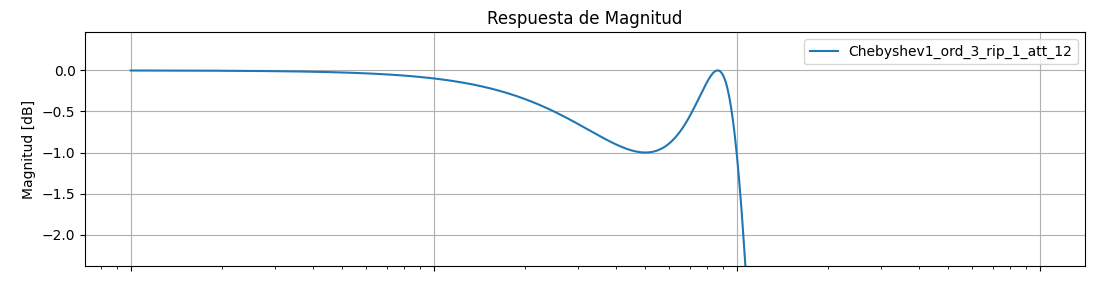

Ahora podemos apreciar como el modulo es 1 cuando caemos en los polos de la sección de orden 2 y pierde 1dB como mucho cuando caemos en el polo de la seccion de primer orden y en la frecuencia de corte.

Ahora el objetivo es diseñar el circuito con componentes pasivos que responda a la transferencia. Comenzamos por la sección de orden 1 proponiendo un inductor en serie y una resistencia en derivación:

$ T_1(S) = \frac{w_0}{S + w_0} = \frac{R_1}{SL_1 + R_1} = \frac{\frac{R_1}{L_1}}{S + \frac{R_1}{L_1}}$

Donde $ w_0 = \frac{R_1}{L_1} $

Normalizamos en frecuencia y luego impedancia respecto de R1: 

$ \frac{R_1}{L_1} = 1 $

$ R_1 = L_1 $ y si R1 = 1: L1 = 1

A continuación un esquema del circuito resultante:

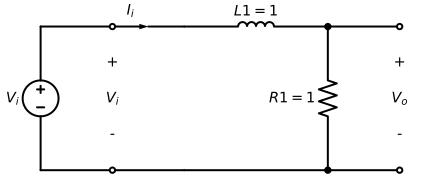

In [4]:
from schemdraw import Drawing
from pytc2.dibujar import dibujar_espacio_derivacion, dibujar_elemento_serie, dibujar_elemento_derivacion, dibujar_puerto_salida, dibujar_puerto_entrada
from pytc2.general import to_latex

d = Drawing(unit=4)
d = dibujar_elemento_derivacion(d, "V",  with_nodes=False, sym_label="V_i")
d = dibujar_espacio_derivacion(d)
d = dibujar_puerto_entrada(d, voltage_lbl=('+', to_latex('V_i'), '-'), current_lbl=to_latex('I_i'))
d = dibujar_elemento_serie(d, "L", sym_label="L1 = 1")
d = dibujar_elemento_derivacion(d, "R", sym_label="R1 = 1")
d = dibujar_puerto_salida(d, voltage_lbl=('+', to_latex('V_o'), '-'))
display(d)

Para la seccion de orden 2 proponemos inductor y resistencia en serie y un capacitor en deviración:

$ T_2(S) = \frac{w_0^{2}}{S^{2} + S\frac{w_0}{Q} + w_0^{2}} = \frac{\frac{1}{SC_2}}{SL_2 + R_2 + \frac{1}{SC_2}} = \frac{\frac{1}{L_2C_2}}{S^{2} + S\frac{R_2}{L_2} + \frac{1}{L_2C_2}}$ 

Donde: 

$ w_0^{2} = \frac{1}{L_2C_2}$

$ \frac{w_0}{Q} = \frac{R_2}{L_2}$

Normalizamos en frecuencia y luego impedancia respecto de R2: 

De $ \frac{1}{L_2C_2} = 1 $ obtenemos $ L_2 = \frac{1}{C_2} $

De $ \frac{1}{Q} = \frac{R_2}{L_2} $ si R2 = 1, obtenemos $ L_2 = Q $ y $ C_2 = \frac{1}{Q}$

A continuación un esquema del circuito resultante:

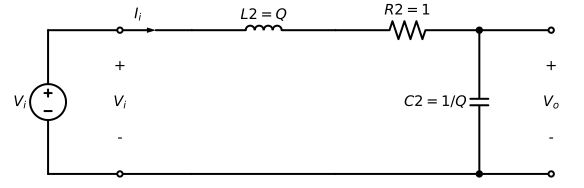

In [8]:
d = Drawing(unit=4)
d = dibujar_elemento_derivacion(d, "V",  with_nodes=False, sym_label="V_i")
d = dibujar_espacio_derivacion(d)
d = dibujar_puerto_entrada(d, voltage_lbl=('+', to_latex('V_i'), '-'), current_lbl=to_latex('I_i'))
d = dibujar_elemento_serie(d, "L", sym_label="L2 = Q")
d = dibujar_elemento_serie(d, "R", sym_label="R2 = 1")
d = dibujar_elemento_derivacion(d, "C", sym_label="C2 = 1/Q")
d = dibujar_puerto_salida(d, voltage_lbl=('+', to_latex('V_o'), '-'))
display(d)

Para obtener la transferencia deseada, conectamos los circuitos de ambas secciones mediante un OP AMP utilizado como buffer. Si ahora tuviesemos que implementar el circuito con un capacitor de 100nF:

$ \frac{w0_2}{Q} = 100 * 10^{-9}Fy * R_2 = 0.494 $

$ R_2 = 4.94M\Omega \cong 5M\Omega $

$ L_2 = R_2 * Q = 5M\Omega * 2.018 = 10.09MHy \cong 10MHy$

O también: $ L_2 = \frac{1}{C_2} = \frac{1}{100 * 10^{-9}Fy} = 10MHy $

Hagamos que $ R_1 = R_2 = 5M\Omega $

Si $ \frac{R_1}{L_1} = 0.4942 $

$ L_1 = \frac{R_1}{0.4942} = 10.12MHy \cong 10MHy$

Ahora tenemos un problema... los inductores suelen ocupar mucho espacio. Por suerte es posible reemplazar los inductores por algún circuito cuya impedancia sea equivalente a la de un inductor. Si tuviesemos solo capacitores, resistores y OP AMPs... implementemos conversores generalizados de inpedancias (GICs). Se sabe que la impedancia de entrada que presenta un GIC es la siguiente:

$ Z_i = \frac{Y_2Y_4}{Y_1Y_3Y_5} $

Si $ Y2 = SC $ y a su vez $ Y1 = Y3 = Y4 = Y5 = \frac{1}{R} $

$ Z_i = \frac{SC * \frac{1}{R}}{\frac{1}{R} * \frac{1}{R} * \frac{1}{R}} = SCR^{2} = SL $ donde $ L = CR^{2} $

Cada inductor es reemplazable por un GIC con 4 resistencias y 1 capacitor cada uno. 